# Deploying Machine Learning Models

* Train a model
* Save the model
* Use the model in a web service

https://github.com/froukje/ml-zoomcamp/blob/main/week5/lecture/Lecture_5_deploying_ml_models.ipynb


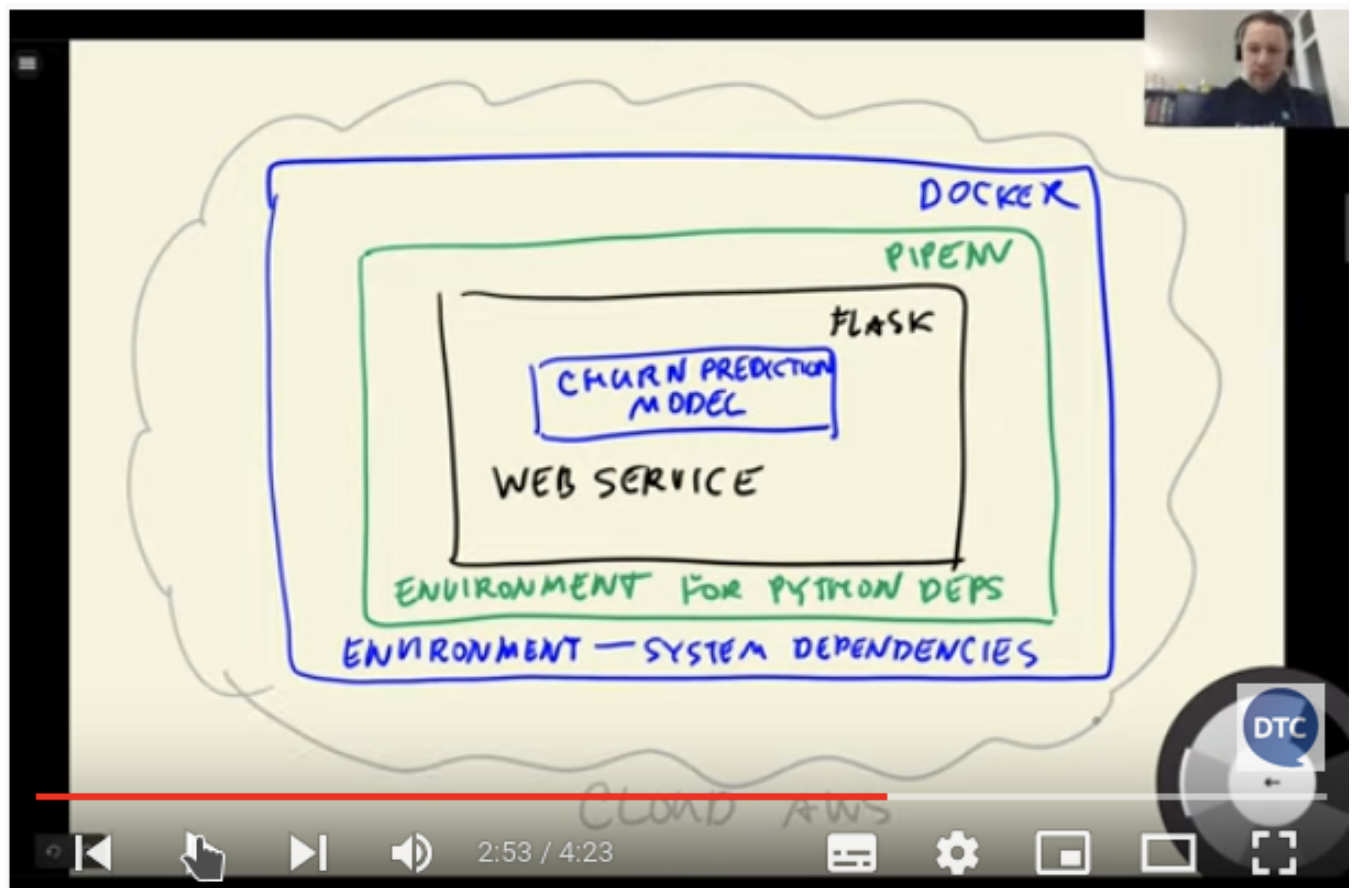

**Code from previous weeks to train the model**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

## Read and prepare the Data

In [ ]:
df = pd.read_csv("telco.csv")

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)


In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [ ]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [ ]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [ ]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [ ]:
C = 1.0
n_splits = 5

In [ ]:
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

In [ ]:
scores

In [ ]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

y_test = df_test.churn.values

auc = roc_auc_score(y_test, y_pred)
auc

## Saving and Loading the Model

* Save the model to pickle
* Load the model from pickle
* Turn our model into a Python script

### Save the model

* Use library "pickle" to write our model into a file 
* Libary to d¿save binary files

In [ ]:
import pickle

In [ ]:
output_file = f"model_C={C}.bin"
output_file

In [ ]:
# write a binary file
f_out = open(output_file,'wb')
# save the model and the dictionary vectorizer (we need that in order to run the model)
pickle.dump((dv, model), f_out)
# close the file
f_out.close()

## Load the Model

* Restart the kernel to pretend we are in a new process, that doesn't know the previous variables
* sklearn does not need to be imported, but needs to be installed

In [18]:
import pickle

In [19]:
model_file = "model_C=1.0.bin"

In [21]:
with open(model_file,'rb') as f_in:
    dv, model = pickle.load(f_in)

dv, model

(DictVectorizer(sparse=False), LogisticRegression(max_iter=1000))

In [22]:
customer = {
    "gender": "female",
    "seniorcitizen": 0,
    "partner": "yes",
    "dependents": "no",
    "phoneservice": "no",
    "multiplelines": "no_phone_service",
    "internetservice": "dsl",
    "onlinesecurity": "no",
    "deviceprotection": "no",
    "techsupport": "no",
    "streamingtv": "no",
    "streamingmovies": "no",
    "contract": "month-to-month",
    "paperlessbilling": "yes",
    "paymentmethod": "electronic_check",
    "tenure": 1,
    "monthlycharges": 29.85,
    "totalcharges": 29.85
}

In [23]:
# turn this customer into a feature matrix
X = dv.transform([customer])

In [26]:
# probabilty that this customer churns
model.predict_proba(X)[0,1]

0.6638191204293116